In [56]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from scipy.fftpack import fft, fftfreq
import scipy as sp

#import betterplot

from scipy import signal

import umap
import umap.plot

from mpl_toolkits.axes_grid1.inset_locator import inset_axes



In [57]:
freqmin = 1
freqmax = 8
sr = 40

reduce_type = np.mean

name_fig = 'figure01'

name = f"final_version/{name_fig}"

savepath = f"/bettik/dokhtdor/projects/mirko_volcano_simulations/figures/{name}/"

os.makedirs(savepath, exist_ok=True)



In [58]:

FILEPATH = "/bettik/dokhtdor/projects/mirko_volcano_simulations/dataset/"

vs = np.load(FILEPATH + 'vs_array.npy') 

data_s1 = np.hstack([np.load(FILEPATH + "z_r1.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r1.npy")[:, np.newaxis,:]] )
data_s2 = np.hstack([np.load(FILEPATH + "z_r2.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r2.npy")[:, np.newaxis,:]] )
data_s3 = np.hstack([np.load(FILEPATH + "z_r_s3.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r_s3.npy")[:, np.newaxis,:]] )
data_s4 = np.hstack([np.load(FILEPATH + "z_r_s4.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r_s4.npy")[:, np.newaxis,:]] )
data_s5 = np.hstack([np.load(FILEPATH + "z_r_s5.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r_s5.npy")[:, np.newaxis,:]] )

# Concatenating the sources 
data = np.concatenate([data_s1, data_s2, data_s3, data_s4, data_s5], axis = 1) #+ 

# Filtering the data
#datafilter = filter(data[:, :], freqmin = freqmin, freqmax = freqmax, fs = 40, order = 2)



from scipy.signal import butter, sosfiltfilt

sos = butter(10, [freqmin, freqmax], 'bandpass', fs=sr, output='sos')
datafilter = sosfiltfilt(sos, data[:,:,:], axis=-1)
datafilter = data[:, : ,:]#[:, np.newaxis, :]


data = datafilter[:,:,:] / np.linalg.norm((datafilter[:, :, :]),ord =2,  axis = -1, keepdims=True)

#data = datafilter[:,:,::1] / np.max(abs(datafilter[:, :, :]),  axis = -1, keepdims=True)

#data  = data[:,:,::1] = data/ np.max(abs(data))


In [59]:
#import ky


In [60]:

[np.linalg.norm(data[i,-5,:]) for i in range(10)]


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [61]:

indx = [15, 35, 55, 75, 95]


In [62]:

from scatseisnet import ScatteringNetwork

segment_duration_seconds = data.shape[-1]/sr

sampling_rate_hertz = sr

samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)


bank_keyword_arguments = (
    {"octaves": 4 , "resolution": 8, "quality": 2, "taper_alpha" : 0.0},
    {"octaves": 5 , "resolution": 8, "quality": 3, "taper_alpha" : 0.0},
     )

# bank_keyword_arguments = (
#     {"octaves": 4 , "resolution": 5, "quality": 2, "taper_alpha" : 0.0},
#     {"octaves": 4 , "resolution": 4, "quality": 3, "taper_alpha" : 0.0},
#      )


bank_keyword_arguments = (
    {"octaves": 4 , "resolution": 8, "quality": 2},
    {"octaves": 4 , "resolution": 8, "quality": 3},
     )


network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
    )

print(network)

for i, bank in enumerate(network.banks):
    print(f"Bank {i}")
    print(bank)
    for j in range(bank.wavelets.shape[0]):
        network.banks[i].wavelets[j] = network.banks[i].wavelets[j] / np.sqrt((np.abs(network.banks[i].wavelets[j])**2).sum())

network.banks[0].spectra = np.fft.fft(network.banks[0].wavelets)
network.banks[1].spectra = np.fft.fft(network.banks[1].wavelets)



ScatteringNetwork(bins=1500, sampling_rate=40, len=2)
ComplexMorletBank(bins=1500, octaves=4, resolution=8, quality=2, sampling_rate=40, len=32)
ComplexMorletBank(bins=1500, octaves=4, resolution=8, quality=3, sampling_rate=40, len=32)
Bank 0
ComplexMorletBank(bins=1500, octaves=4, resolution=8, quality=2, sampling_rate=40, len=32)
Bank 1
ComplexMorletBank(bins=1500, octaves=4, resolution=8, quality=3, sampling_rate=40, len=32)


In [63]:

np.max((network.banks[0].wavelets[0].real))


0.19398097284180407

/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


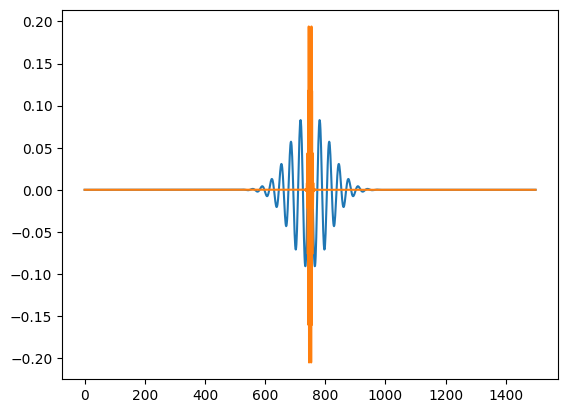

In [64]:
plt.plot(network.banks[0].wavelets[-1])

plt.plot(network.banks[0].wavelets[0])#/np.max(abs(network.banks[0].wavelets[0])))
#plt.xlim(700, 800)


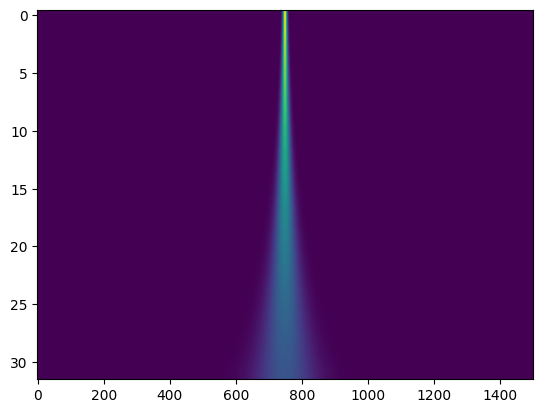

In [65]:
plt.imshow(abs(network.banks[0].wavelets), aspect='auto')

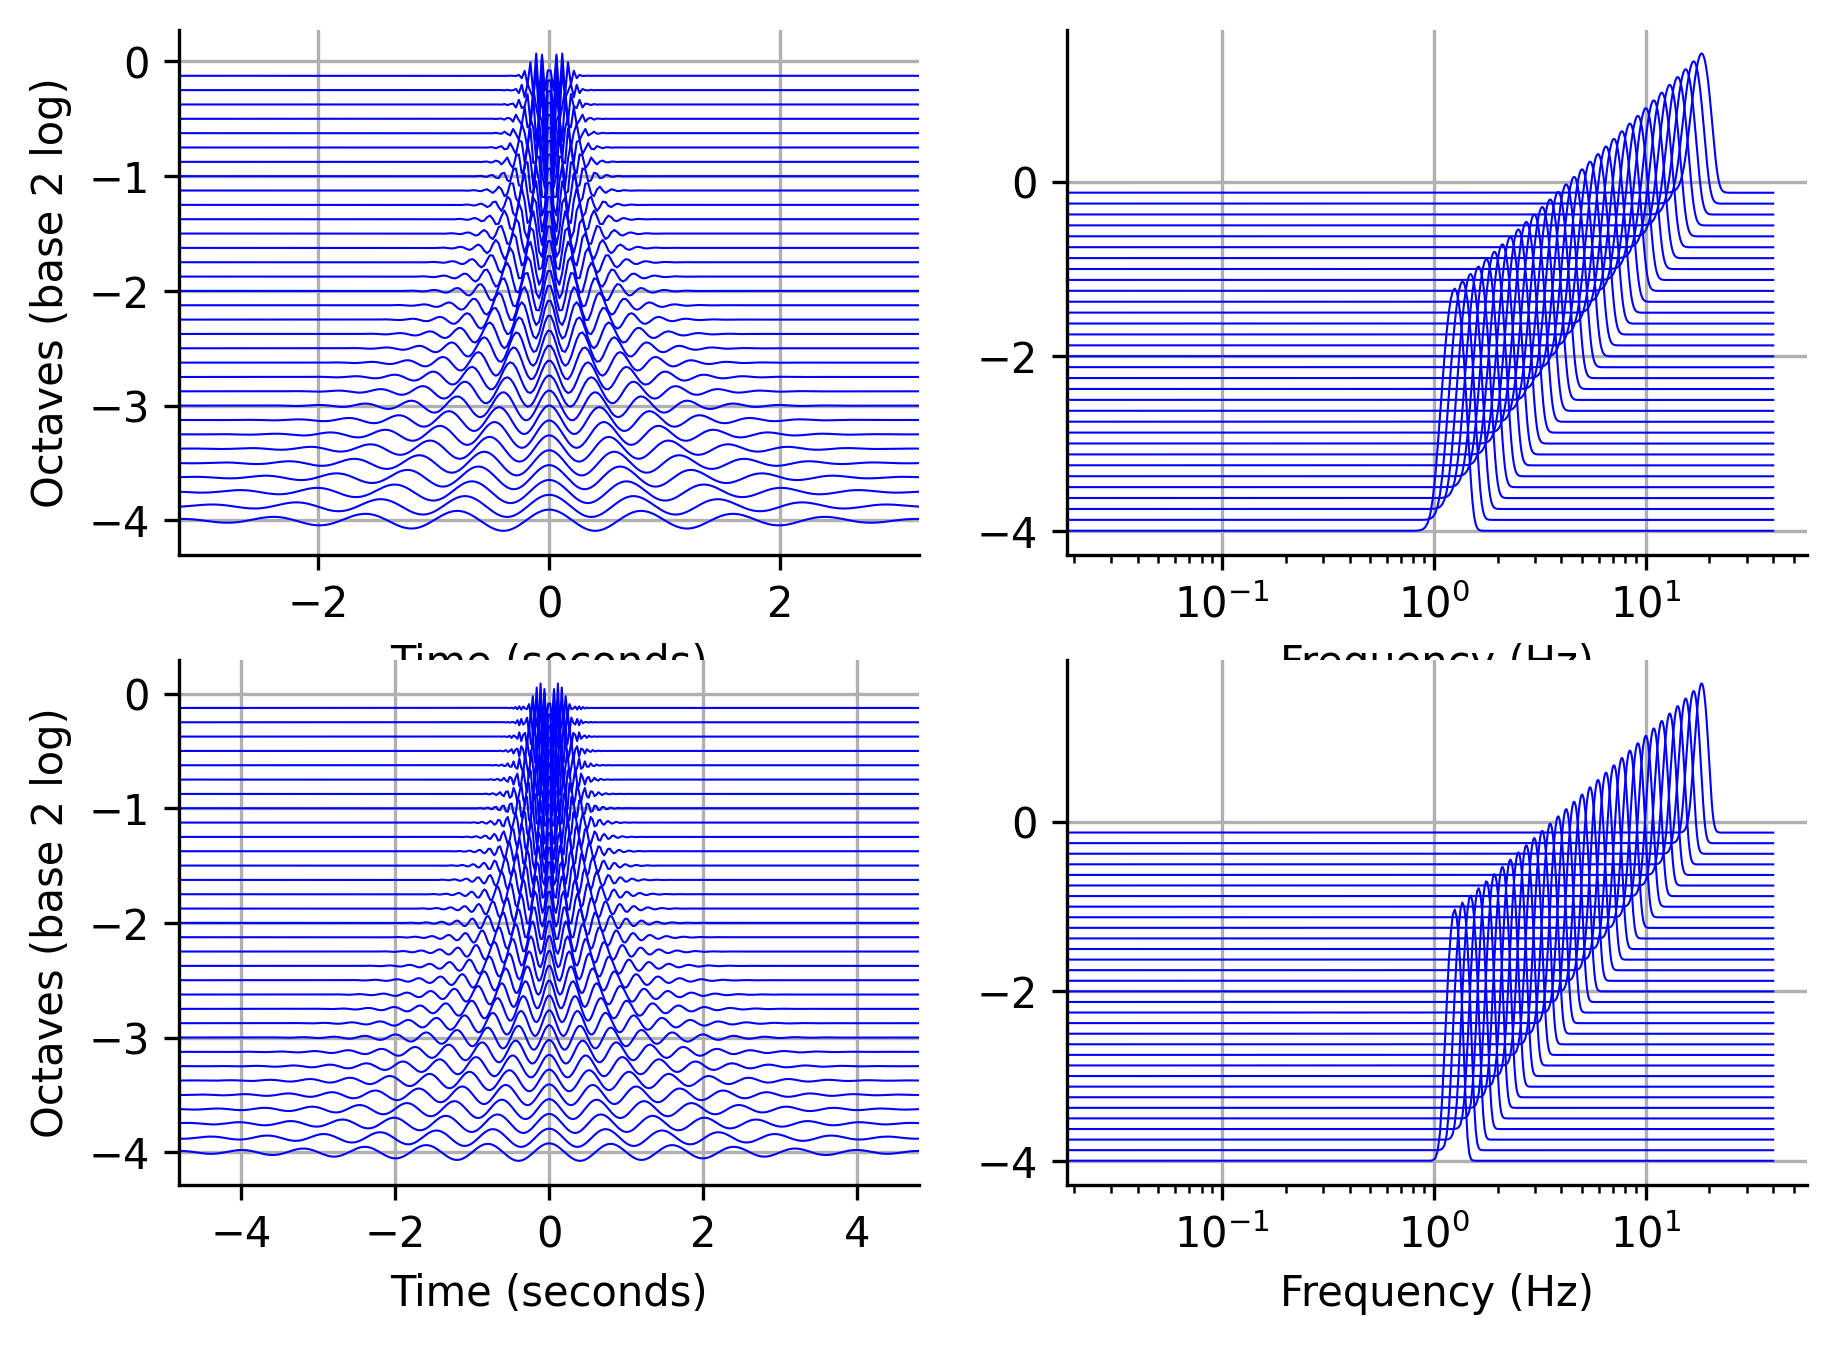

In [66]:

# Loop over network layers
#plt.figure(figsize=(10,5))

#cc = low_pass_filter(2000, sigma = 0.2)
fig, ax = plt.subplots(2, 2, figsize=(7,5),  dpi =300)


for i, bank in enumerate(network.banks):

    # Create axes (left for temporal, right for spectral domain)
    
    ii = 0
    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets[:], bank.spectra[:], bank.ratios[:]
    ):

        # Time domain
        ax[i,0].plot(bank.times, wavelet.real + ratio, c= 'b', lw = 0.5)
        #ax[i,0].plot(bank.times, wavelet.imag + ratio, c='r', lw = 0.5)

        # Spectral domain (log of amplitude)
        ax[i,1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, c = 'b', lw = 0.5)
        #ax[i,2].plot(bank.frequencies, np.log(np.abs(spectrum*cc[1000:]) + 1) + ratio, c = 'b', lw = 0.5)
        
    #ax[0,1].plot(bank.frequencies, np.log(np.abs(cc[1000:]) + 1) -0.25, c = 'r', lw = 0.5)

    # Limit view to three times the temporal width of largest wavelet
    width_max = 2 * bank.widths.max()

    # Labels
    
    
    ax[i,0].set_ylabel("Octaves (base 2 log)")
    ax[i,0].set_xlabel("Time (seconds)")
    ax[i,0].set_xlim(-width_max, width_max)
    ax[i,0].grid()
    ax[i,1].set_xscale("log")
    ax[i,1].set_xlabel("Frequency (Hz)")
    ax[i,1].grid()

    #ax[i, 0].set_xlim(0.1, 50)
    #  
    #ax[i,2].set_xscale("log")
    #ax[i,2].set_xlabel("Frequency (Hz)")
    #ax[i,2].grid()
    #ax[i, 1].set_xlim(0.1, 50)
    
    ii = ii+1

for axn in ax.flat:
    axn.spines['top'].set_visible(False)
    axn.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)


In [67]:
time = np.arange(0, data.shape[-1], 1) / sr

indxvs = np.arange(120*65).reshape(120, 65)

indx = [15, 35, 55, 75, 95]


In [33]:
segments = [data[i,:,:] for i in indxvs[indx, 30]]


sc1 = network.transform(segments,  reduce_type= None )


sc1med = network.transform(segments,  reduce_type= np.median )

sc1mean = network.transform(segments,  reduce_type= np.mean )
sc1max = network.transform(segments,  reduce_type= np.max )


for i in range(len(network.banks[0].centers)):

    n = network.banks[0].centers[i] <= network.banks[1].centers  # Find the center of the wavelet in the second layer that is closest to the center of the wavelet in the first layer
    sc1mean[1][:,:, i, n] = np.nan
    sc1med[1][:,:, i, n] = np.nan
    sc1max[1][:,:, i, n] = np.nan

    

In [ ]:
plt.plot(segments[0][0,:])

In [ ]:

network.banks[0].centers.shape

In [ ]:
plt.figure(figsize = (10, 5))

#plt.imshow(sc1[1][-1, 0, 4], aspect ='auto')

plt.pcolor(time, network.banks[1].centers, sc1[1][0, 0, 10],  cmap="PuBu", rasterized=True, )

plt.ylim(0, 8)

In [19]:


trc = [0 , -1]



In [ ]:
import seaborn as sns

cmap2 = sns.color_palette("hls", 3)

print(cmap2.as_hex())

cmap2


In [ ]:

plt.plot(abs(np.fft.fft(segments[-1][0])))
plt.plot()
plt.xlim(0, 400)

In [22]:



from  matplotlib import ticker
mticker = ticker.ScalarFormatter(useOffset=False)


In [ ]:

gs = {"hspace": 0.5, "wspace": 0.1, "height_ratios": [1.25,3, 2, 3, 3]}
fig, axs = plt.subplots(
        5, 2, figsize=(8, 10), sharex="row", sharey="row", gridspec_kw=gs
    )

ax = axs[0].reshape(-1)

ifig_caption = ['a.', 'b.', 'c.']
for i, ind in enumerate(trc):

    ax[i].plot(time, segments[ind][0], lw = 0.5, c = '#5770db')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_xlim(0, 37)

    ax[i].set_title(ifig_caption[i], loc = 'left', fontweight = 'bold') 



ax = axs[1].reshape(-1)
ifig_caption = ['c.', 'd.', 'e.', 'f.']
for i, ind in enumerate(trc):

    im1 = ax[i].pcolor(time, network.banks[0].centers, (sc1[0][ind, 0])**1, vmin =0, vmax = 0.5,  cmap="PuBu", rasterized=True, )
    #ax[i].set_xlabel('1st order \n frequency (Hz)')
    ax[i].set_ylim(1, 10)
    
    print(np.linalg.norm(sc1[0][ind , 0]))

    ax[i].set_xlabel('Time (s)')
    axins1 = inset_axes(
        ax[i],
        width="40%",  # width: 50% of parent_bbox width
        height="5%",  # height: 5%
        loc="upper left",
    )
    axins1.xaxis.set_ticks_position("bottom")
    fig.colorbar(im1, cax=axins1, orientation="horizontal", )

    ax[i].set_title(ifig_caption[i], loc = 'left', fontweight = 'bold') 


ax[0].set_ylabel("Frequency (Hz)")

    

ax = axs[2].reshape(-1)

ifig_caption = ['e.', 'f.', 'h.', 'i.']
for i, ind in enumerate(trc):
    axtwin = ax[i].twinx()
    l1,  = axtwin.plot(np.fft.fftfreq(1500, 1/sr)[:750], abs(sp.fftpack.fft(segments[ind][0]))[:750], label = 'FFT', c = '#57db5f', lw = 2, alpha = 0.5)
    if i ==0: axtwin.set_yticklabels([])
    
    l2,  = ax[i].plot(network.banks[0].centers, (sc1mean[0][ind][0])*1, lw = 2, label = 'mean op.', c = '#db5f57')
    l3,  = ax[i].plot(network.banks[0].centers, (sc1med[0][ind][0])*1, lw = 2, label = 'median op.', c = '#5770db')
    
    ax[i].set_xlim(1, 10)
    ax[i].set_title(ifig_caption[i], loc = 'left', fontweight = 'bold') 


ax[i].legend(handles=[l1, l2, l3], loc = 'upper right')
ax[0].set_ylabel("Scattering \n coefficients (order 1)")
axtwin.set_ylabel('Amplitude')



ax = axs[3].reshape(-1)
ifig_caption = ['g.', 'h.', 'l.']  
for i, ind in enumerate(trc):

    nn = ((sc1med[1][ind, 0]**0.5).T)
    nn = nn #*(1.2)**(i+1)#- np.median(np.log(sc1med[1]**1), axis = 0)[0].T
    print(np.nanmax(nn)*1.2)

    im1 = ax[i].pcolor(network.banks[0].centers, network.banks[1].centers, nn,
                 cmap = 'RdYlBu_r', vmin =0, 
                rasterized=True, edgecolors='k',
                 linewidths=0.1
                 )
    
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].grid(True)

    #ax[i].set_xlabel('1st order \n central frequency (Hz)')

    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,10)

    axins1 = inset_axes(
        ax[i],
        width="40%",  # width: 50% of parent_bbox width
        height="5%",  # height: 5%
        loc="upper left",
    )

    axins1.tick_params(axis="x", which="both", rotation=90)

    axins1.xaxis.set_ticks_position("top")
    fig.colorbar(im1, cax=axins1, orientation="horizontal")
    
    ax[i].set_title(ifig_caption[i], loc = 'left', fontweight = 'bold') 
    ax[i].tick_params(axis="x", which="both", rotation=35)

    ax[i].yaxis.set_minor_formatter(ticker.NullFormatter())


ax[0].set_ylabel("2nd order \n central frequency (Hz)")

ax = axs[4].reshape(-1)
ifig_caption = ['i.', 'j.', 'l.']  
for i, ind in enumerate(trc):
    nn = ((sc1mean[1][ind, 0]**0.5).T)
    nn = nn #- np.median(np.log(sc1mean[1]**1), axis = 0)[0].T
    im1 = ax[i].pcolor(network.banks[0].centers, network.banks[1].centers, nn, 
                        vmin =0, 
                        cmap = 'RdYlBu_r', rasterized=True, 
                        edgecolors='k', linewidths=0.1
                        )


    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    #ax[i].grid(True)

    ax[i].set_xlabel('1st order \n central frequency (Hz)')

    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,10)

    axins1 = inset_axes(
        ax[i],
        width="40%",  # width: 50% of parent_bbox width
        height="5%",  # height: 5%
        loc="upper left",
    )
    
    axins1.tick_params(axis="x", which="both", rotation=90)

    axins1.xaxis.set_ticks_position("top")
    fig.colorbar(im1, cax=axins1, orientation="horizontal")
    
    ax[i].set_title(ifig_caption[i], loc = 'left', fontweight = 'bold') 
    ax[i].tick_params(axis="x", which="both", rotation=35)

    ax[i].yaxis.set_minor_formatter(mticker)
    ax[i].yaxis.set_minor_formatter(ticker.NullFormatter())



ax[0].set_ylabel("2nd order \n central frequency (Hz)")

plt.tight_layout()

fig.savefig(savepath + f'Figure01_comparision.png', transparent=True, dpi = 300)



In [ ]:


['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

